# Set up

In [1]:
from ast import literal_eval
from pathlib import Path
from tqdm import tqdm
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from natsort import natsorted
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def safe_literal_eval(s: str) -> Any:
    try:
        # Attempt to evaluate the string as a Python literal
        if s == "[]":
            return []
        return literal_eval(s)
    except ValueError:
        # Return the original string if literal_eval fails
        return s


def objective(beta: float) -> float:
    result = (1 - beta**8) / (1 - beta**1)
    return result


def beta_ema(beta_list: List[float], factor: float) -> float:
    beta_ema = beta_list[0]

    for i in range(1, len(beta_list)):
        beta_ema = beta_ema * (1 - factor) + beta_list[i] * factor

    return beta_ema


def objective(beta):
    result = (1 - beta**8) / (1 - beta**1)
    return result


def objective_round(beta):
    a = 8
    b = 1
    result = (1 - beta**a) / (1 - beta**b)

    return round(result - 1)


# def polynomial_fit(beta):
#     a = 25.48
#     b = -31.4
#     c = 12.35
#     d = -0.2614
#     result = a * beta**3 + b * beta**2 + c * beta + d
#     return round(result)


def polynomial_fit(beta):
    # 58.97 x - 96.03 x + 49.74 x - 6.746 x + 0.8232
    a = 58.97
    b = -96.03
    c = 49.74
    d = -6.746
    e = 0.8232
    result = a * beta**4 + b * beta**3 + c * beta**2 + d * beta + e
    return round(result)


def process_result_file(fname: Path) -> Tuple[str, pd.DataFrame]:
    # read only the first 100 lines
    with open(fname, "r") as f:
        config = f.readline()
    df = pd.read_csv(fname, sep="|", header=None, skiprows=1)
    df.columns = [
        "dummy",
        "accept_cnt",
        "previous_beta_list",
        "draft_probs",
        "accept_cnt_list",
        "accept_probs",
        "current_beta_list",
    ]

    df["accept_cnt"] = df["accept_cnt"].astype(int)
    df["previous_beta_list"] = df["previous_beta_list"].apply(
        lambda x: safe_literal_eval(x.strip())
    )
    df["draft_probs"] = df["draft_probs"].apply(lambda x: safe_literal_eval(x.strip()))
    df["accept_cnt_list"] = df["accept_cnt_list"].apply(
        lambda x: safe_literal_eval(x.strip())
    )
    df["accept_probs"] = df["accept_probs"].apply(
        lambda x: safe_literal_eval(x.strip())
    )
    df["current_beta_list"] = df["current_beta_list"].apply(
        lambda x: safe_literal_eval(x.strip())
    )

    df = df.dropna()
    df = df.drop(columns=["dummy"])

    # if len of previous_beta_list is 0, drop the row
    df = df[df["previous_beta_list"].map(len) > 0]

    # apply beta_ema to previous_beta_list
    df["beta_ema"] = df["previous_beta_list"].apply(lambda x: beta_ema(x, 0.5))

    return config, df


def load_compressed_results(fname: Path) -> Dict[str, Any]:
    suffix = fname.suffix.lstrip(".")
    return pd.read_pickle(fname, compression=None if suffix == "pkl" else suffix)


RESULT_DIR = Path("5_04_result")
RESULT_FILES = natsorted(RESULT_DIR.iterdir())
# RESULT_FILES = [f for f in RESULT_FILES if f.suffix == ".pkl"]
RESULT_FILES = [f for f in RESULT_FILES if f.suffix == ".xz"]

# Visualizing the results

In [2]:
class GridPlotter:
    nrows: int
    ncols: int
    tight_layout: bool
    kwargs: Dict[str, Any]

    _counter: int
    _axs: Optional[Union[Axes, np.ndarray]]
    _fig: Optional[plt.Figure]

    def __init__(
        self, nrows: int = 1, ncols: int = 1, tight_layout: bool = True, **kwargs
    ):
        if nrows <= 0 and ncols <= 0:
            raise ValueError("Either nrows or ncols must be positive.")
        self.nrows = nrows
        self.ncols = ncols
        self.tight_layout = tight_layout
        self.kwargs = kwargs

        self._counter = 0
        self._axs = None
        self._fig = None

    def iteraxs(self, count: int = -1) -> Iterable[Axes]:
        self.reset()
        nrows, ncols = self.get_grid_shape(count)
        fig, axs = plt.subplots(nrows, ncols, **self.kwargs)
        self._fig, self._axs = fig, axs
        if self.tight_layout:
            fig.tight_layout()

        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for i in range(max(ncols, nrows)):
                    if self._counter == count:
                        break
                    self._counter += 1
                    yield axs[i]
            else:
                for i in range(nrows):
                    for j in range(ncols):
                        if self._counter == count:
                            break
                        self._counter += 1
                        yield axs[i, j]
        else:
            self._counter += 1
            yield axs

    def show(self):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.show()
        self.reset()

    def savefig(self, path: Path):
        if self._fig is None:
            raise ValueError("No figure to save.")
        self.finish()
        self._fig.savefig(path)

    def finish(self):
        if self._axs is None or self._fig is None:
            return
        axs = self._axs
        if isinstance(axs, np.ndarray):
            if axs.ndim == 1:
                for ax in axs[self._counter :]:
                    ax.axis("off")
            else:
                start_row = self._counter // axs.shape[1]
                start_col = self._counter % axs.shape[1]
                for i in range(start_row, axs.shape[0]):
                    if i == start_row:
                        for j in range(start_col, axs.shape[1]):
                            axs[i, j].axis("off")
                    else:
                        for j in range(axs.shape[1]):
                            axs[i, j].axis("off")
        else:
            if self._counter == 0:
                axs.axis("off")

    def reset(self):
        self._counter = 0
        self._axs = None
        self._fig = None

    def get_grid_shape(self, count: int = -1) -> Tuple[int, int]:
        if self.nrows <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            nrows = int(np.ceil(count / self.ncols))
        else:
            nrows = self.nrows
        if self.ncols <= 0:
            if count < 0:
                raise ValueError("count must not be negative.")
            ncols = int(np.ceil(count / self.nrows))
        else:
            ncols = self.ncols
        return nrows, ncols

    def update(self, **kwargs):
        self.kwargs.update(kwargs)


def plot_accept_cnt_dist(df: pd.DataFrame, ax: Optional[Axes] = None):
    # Determine the range for the bins
    max_value = df["accept_cnt"].max()
    bins = np.arange(
        -0.5, max_value + 1.5
    )  # Extending to max_value + 1 and starting from -0.5

    # Plotting the distribution of accept_cnt
    if ax is None:
        _, ax = plt.subplots()
    ax.hist(
        df["accept_cnt"], bins=bins, edgecolor="black", align="mid"
    )  # Aligns the bins centered on integers
    ax.set_xlabel("accept_cnt")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of accept_cnt")
    ax.set_xticks(
        range(max_value + 1)
    )  # Setting x-axis ticks to cover all integer values from 0 to max_value


def plot_beta_ema_dist(df: pd.DataFrame, ax: Optional[Axes] = None):
    # the beta values are between 0 and 1
    bins = np.linspace(0, 1, 21)  # 20 bins between 0 and 1

    # Plotting the distribution of beta_ema
    if ax is None:
        _, ax = plt.subplots()
    ax.hist(
        df["beta_ema"], bins=bins, edgecolor="black", align="mid"
    )  # Aligns the bins centered on integers
    ax.set_xlabel("beta_ema")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of beta_ema")


def plot_accept_cnt_vs_beta(df: pd.DataFrame, ax: Optional[Axes] = None):
    # Define the bin edges
    bin_edges = np.linspace(0, 1, 21)  # 20 bins between 0 and 1

    # Assign bin numbers
    df["beta_bin"] = pd.cut(
        df["beta_ema"], bins=bin_edges, labels=False, include_lowest=True
    )

    # Group by 'beta_bin' and calculate statistics
    df_grouped = df.groupby("beta_bin").agg(
        {"accept_cnt": ["mean", "median", "std"], "beta_ema": "mean"}
    )
    df_grouped.columns = [
        "accept_cnt_mean",
        "accept_cnt_median",
        "accept_cnt_std",
        "beta_mean",
    ]  # Simplify column names
    df_grouped.reset_index(inplace=True)

    # Calculate average standard deviation
    average_std = df_grouped["accept_cnt_std"].mean()

    # Generate bin labels for x-axis
    bin_labels = [
        f"{edge:.2f} - {bin_edges[i+1]:.2f}" for i, edge in enumerate(bin_edges[:-1])
    ]
    df_grouped["beta_bin_labels"] = bin_labels

    # Calculate the objective function value for each bin
    df_grouped["objective"] = df_grouped["beta_mean"].apply(objective)
    df_grouped["objective_round"] = df_grouped["beta_mean"].apply(objective_round)
    df_grouped["polynomial_fit"] = df_grouped["beta_mean"].apply(polynomial_fit)

    # Fit polynomial to median acceptance counts
    beta_vals = df_grouped["beta_mean"].values
    accept_cnt_medians = df_grouped["accept_cnt_median"].values
    p = np.polyfit(beta_vals, accept_cnt_medians, 4)
    polynomial_function = np.poly1d(p)

    # Print the polynomial function equation
    print("Polynomial Function Equation:")
    print(polynomial_function)

    # Plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 12))
    bar_plot = ax.bar(
        df_grouped["beta_bin_labels"],
        df_grouped["accept_cnt_mean"],
        yerr=df_grouped["accept_cnt_std"],
        color="skyblue",
        capsize=5,
    )
    line_plot = ax.plot(
        df_grouped["beta_bin_labels"],
        df_grouped["accept_cnt_median"],
        color="blue",
        marker="x",
        linestyle="-",
    )[0]
    objective_plot = ax.plot(
        df_grouped["beta_bin_labels"],
        df_grouped["objective"],
        color="red",
        marker="o",
        linestyle="-",
    )[0]
    # objective_round_plot = ax.plot(df_grouped['beta_bin_labels'], df_grouped['objective_round'], color='black', marker='o', linestyle='-')[0]
    polynomial_fit_plot = ax.plot(
        df_grouped["beta_bin_labels"],
        df_grouped["polynomial_fit"],
        color="black",
        linestyle="-",
    )[0]

    ax.set_xlabel("Beta Bins")
    ax.set_ylabel("Average Acceptance Count")
    ax.set_xticks(range(len(bin_labels)))  # Set x-tick positions
    ax.set_xticklabels(bin_labels, rotation=45)  # Set x-tick labels and rotate them

    # Properly setting the legend by providing handles and labels
    ax.legend(
        [bar_plot, line_plot, objective_plot, polynomial_fit_plot],
        [
            f"Mean Accept Count (Avg Std-Dev: {average_std:.2f})",
            "Median Accept Count",
            "(1-beta^8)/(1-beta)",
            "25.48*beta^3 - 31.4*beta^2 + 12.35*beta - 0.2614",
        ],
        loc="upper left",
    )


def get_accept_cnt_vs_draft_prob(df: pd.DataFrame) -> pd.DataFrame:
    # if the index is smaller than accept_cnt, then it is accepted
    # if the index is exactly same to accept_cnt, then it is rejected
    # if the index is larger than accept_cnt, then it is not considered

    # Initialize an empty list to store data
    data = []

    # Iterate over each row in the original dataframe
    for _, row in df.iterrows():
        beta_ema = row["beta_ema"]
        # Iterate over each draft_prob in the row
        for i, draft_prob in enumerate(row["draft_probs"]):
            # Check if the current index matches or is less than the accept count
            if i < row["accept_cnt"]:
                accepted = 1
            elif i == row["accept_cnt"]:
                accepted = 0
            else:
                continue

            # Append a tuple to the list
            data.append((beta_ema, draft_prob, accepted))

    # Create the DataFrame from the list
    df_draft = pd.DataFrame(data, columns=["beta_ema", "draft_prob", "accepted"])
    return df_draft


def bin_draft_accepted_df(
    draft_accepted_df: pd.DataFrame, num_bins: int = 20, agg: str = "mean"
) -> pd.DataFrame:
    # Define bins
    beta_ema_bins = np.linspace(0, 1, num_bins + 1)
    draft_prob_bins = np.linspace(0, 1, num_bins + 1)

    # Binning the data
    draft_accepted_df["beta_ema_binned"] = pd.cut(
        draft_accepted_df["beta_ema"],
        bins=beta_ema_bins,
        labels=np.linspace(0, 1, num_bins, endpoint=False),
    )
    draft_accepted_df["draft_prob_binned"] = pd.cut(
        draft_accepted_df["draft_prob"],
        bins=draft_prob_bins,
        labels=np.linspace(0, 1, num_bins, endpoint=False),
    )

    # Group and aggregate data
    binned_df = (
        draft_accepted_df.groupby(["beta_ema_binned", "draft_prob_binned"])
        .agg({"accepted": agg})
        .fillna(0)
    )
    binned_df.reset_index(inplace=True)

    # Convert categories to codes to be used in regression
    binned_df["beta_ema_binned_code"] = binned_df["beta_ema_binned"].cat.codes
    binned_df["draft_prob_binned_code"] = binned_df["draft_prob_binned"].cat.codes

    return binned_df


def plot_accept_prob_heatmap(binned_df: pd.DataFrame, ax: Optional[Axes] = None):
    # Pivot table for the heatmap
    pivotted_df = binned_df.pivot(
        index="beta_ema_binned", columns="draft_prob_binned", values="accepted"
    )

    # Plotting the actual data
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(
        pivotted_df,
        cmap="Accent",
        interpolation="nearest",
        origin="lower",
        extent=[0, 1, 0, 1],
    )
    plt.colorbar(im, cax=cax, ax=ax)
    ax.set_xlabel("Draft Probability")
    ax.set_ylabel("Beta EMA")
    ax.set_title("Actual Acceptance Rate Heatmap")


def plot_predicted_accept_prob_heatmap(
    binned_df: pd.DataFrame,
    ax: Optional[Axes] = None,
):
    # Prepare data for regression
    X = binned_df[["beta_ema_binned_code", "draft_prob_binned_code"]].values
    y = binned_df["accepted"].values

    # Polynomial features
    poly = PolynomialFeatures(degree=3, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Linear regression
    model = LinearRegression()
    model.fit(X_poly, y)

    # Make predictions using the model over the grid
    X_grid = np.array([(beta, draft) for beta in range(21) for draft in range(21)])
    X_grid_poly = poly.transform(X_grid)
    y_grid_pred = model.predict(X_grid_poly).reshape(21, 21)

    # Plotting predicted data
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(
        y_grid_pred,
        cmap="Accent",
        interpolation="nearest",
        origin="lower",
        extent=[0, 1, 0, 1],
    )
    plt.colorbar(im, cax=cax, ax=ax)
    ax.set_xlabel("Draft Probability")
    ax.set_ylabel("Beta EMA")
    ax.set_title("Predicted Acceptance Rate Heatmap")


def load_config_binned_df(
    result_file: Path, bin_agg: Optional[str] = None
) -> Tuple[str, pd.DataFrame]:
    if result_file.suffix == ".csv":
        config, df = process_result_file(result_file)
        draft_accepted_df = get_accept_cnt_vs_draft_prob(df)
        binned_df = bin_draft_accepted_df(draft_accepted_df, agg=bin_agg or "mean")
    elif result_file.suffix in (".xz", ".pkl"):
        result_dict = load_compressed_results(result_file)
        config = result_dict["config"]
        binned_df = (
            result_dict["binned_df"]
            if bin_agg is None
            else bin_draft_accepted_df(result_dict["draft_accepted_df"], agg=bin_agg)
        )
    else:
        raise ValueError(f"Unsupported file extension: {result_file.suffix}")
    return config, binned_df


MAX_COLS = 5

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 22.73it/s]


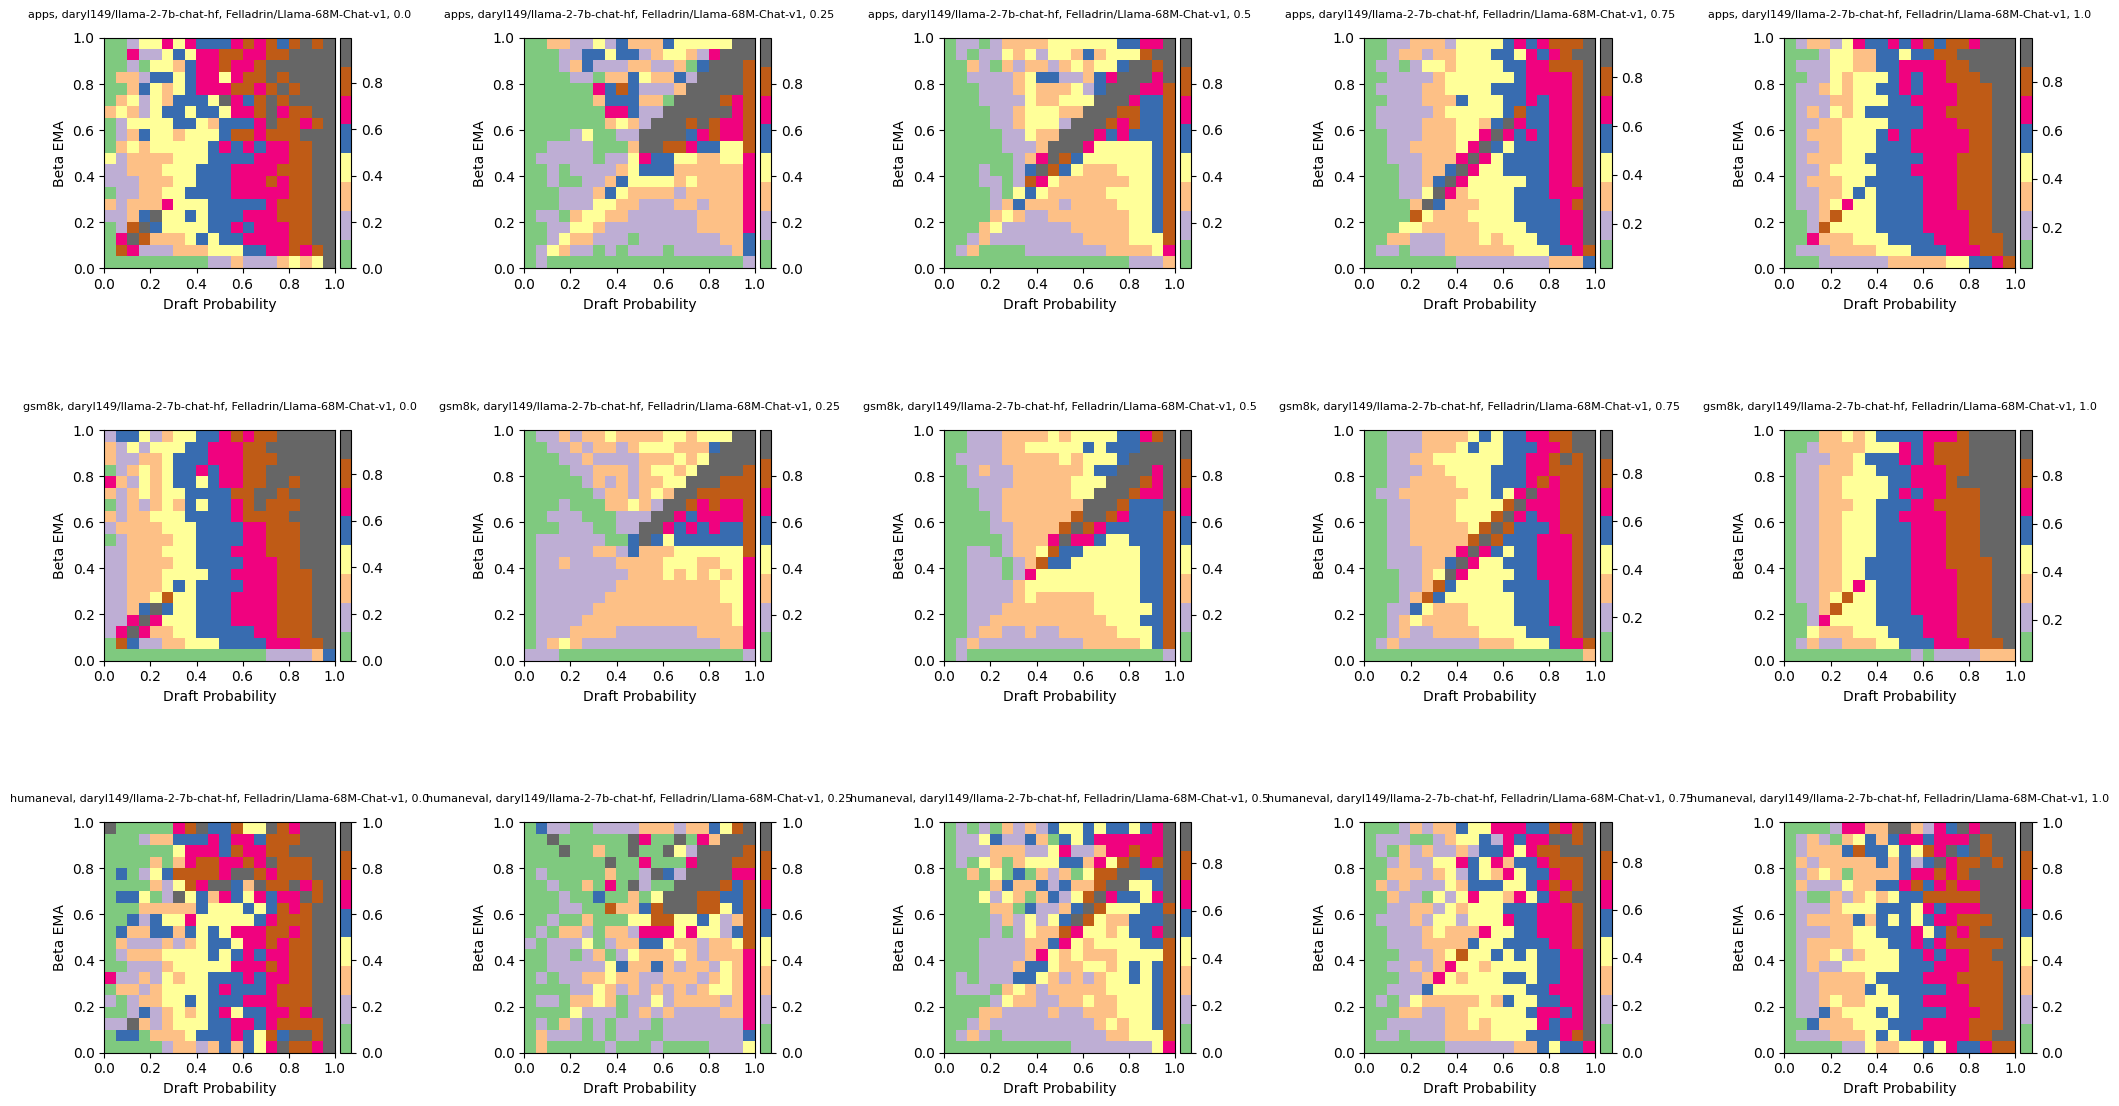

In [3]:
num_results = len(RESULT_FILES)
ncols = min(num_results, MAX_COLS)
nrows = int(np.ceil(num_results / MAX_COLS))
plotter = GridPlotter(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
for result_file, ax in tqdm(zip(RESULT_FILES, plotter.iteraxs()), total=num_results):
    try:
        config, binned_df = load_config_binned_df(result_file)
    except:
        continue
    plot_accept_prob_heatmap(binned_df, ax=ax)
    ax.set_title(config, fontsize=8)
plt.subplots_adjust(wspace=0.7, hspace=0.1)

100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


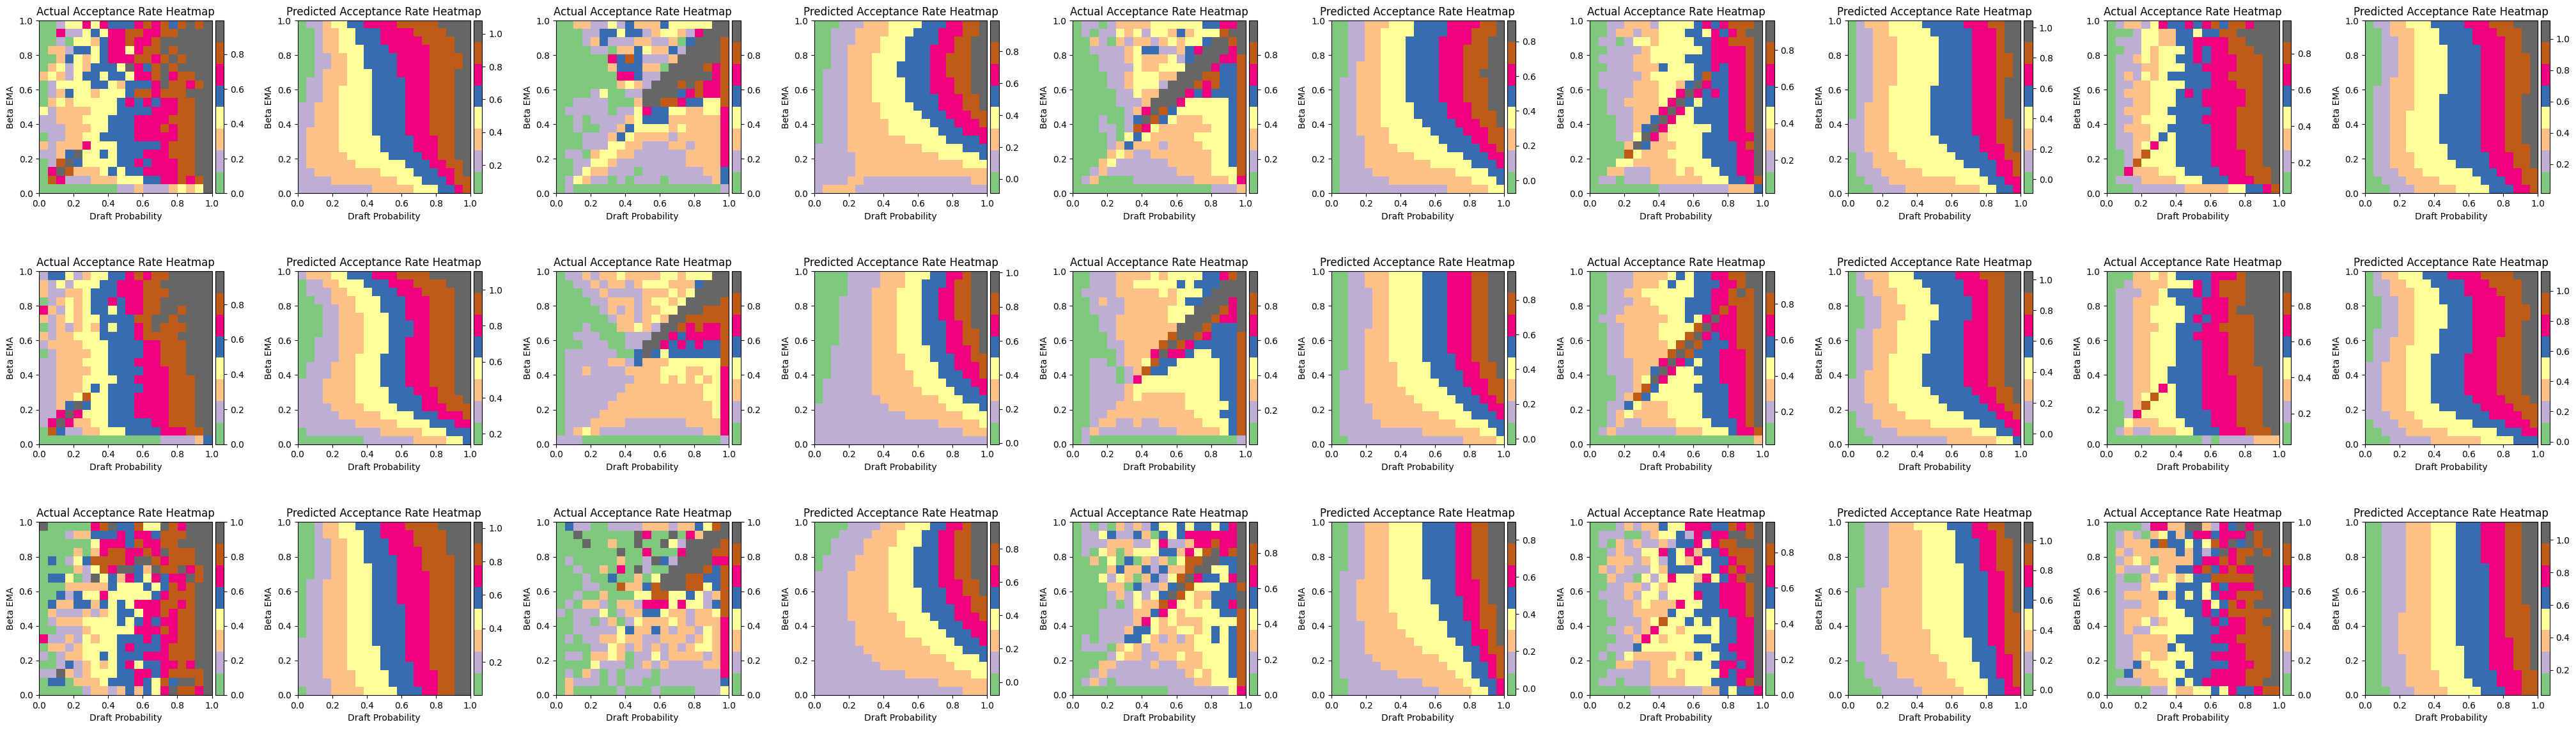

In [4]:
num_results = len(RESULT_FILES)
ncols = min(num_results * 2, MAX_COLS * 2)
nrows = int(np.ceil(num_results / MAX_COLS))
plotter = GridPlotter(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
ax_iter = plotter.iteraxs()
for result_file in tqdm(RESULT_FILES):
    try:
        config, binned_df = load_config_binned_df(result_file)
    except:
        continue
    plot_accept_prob_heatmap(binned_df, ax=next(ax_iter))
    plot_predicted_accept_prob_heatmap(binned_df, ax=next(ax_iter))
plt.subplots_adjust(wspace=0.4, hspace=0.1)

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_4129776/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draft_accepted_df.groupby(["beta_ema_binned", "draft_prob_binned"])
  7%|▋         | 1/15 [00:28<06:45, 28.98s/it]/tmp/ipykernel_4129776/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draft_accepted_df.groupby(["beta_ema_binned", "draft_prob_binned"])
 13%|█▎        | 2/15 [01:21<09:18, 42.97s/it]/tmp/ipykernel_4129776/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

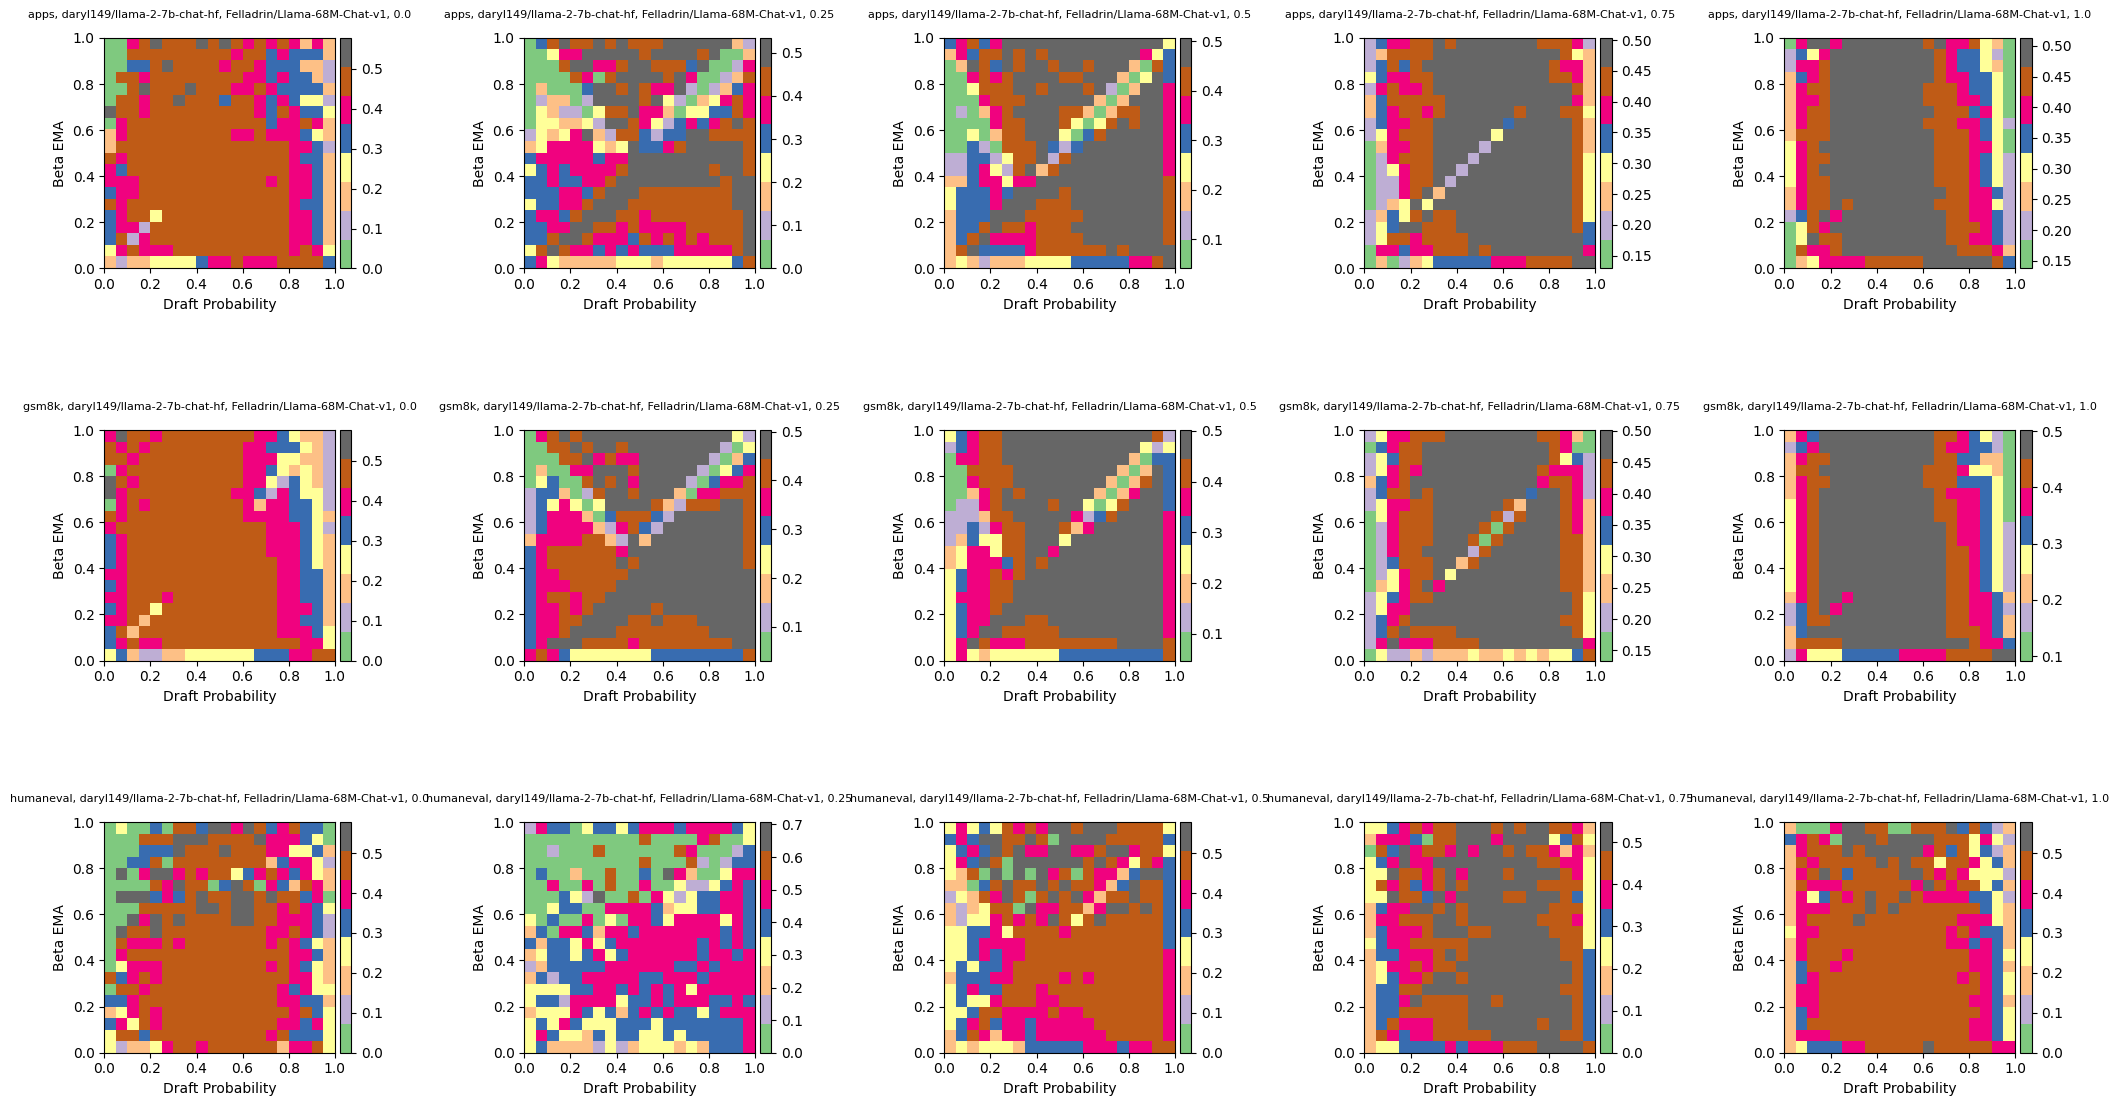

In [3]:
num_results = len(RESULT_FILES)
ncols = min(num_results, MAX_COLS)
nrows = int(np.ceil(num_results / MAX_COLS))
plotter = GridPlotter(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
for result_file, ax in tqdm(zip(RESULT_FILES, plotter.iteraxs()), total=num_results):
    try:
        config, binned_df = load_config_binned_df(result_file, "std")
    except:
        continue
    plot_accept_prob_heatmap(binned_df, ax=ax)
    ax.set_title(config, fontsize=8)
plt.subplots_adjust(wspace=0.7, hspace=0.1)

  0%|          | 0/15 [00:00<?, ?it/s]/tmp/ipykernel_4155567/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draft_accepted_df.groupby(["beta_ema_binned", "draft_prob_binned"])
  7%|▋         | 1/15 [00:29<06:46, 29.06s/it]/tmp/ipykernel_4155567/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  draft_accepted_df.groupby(["beta_ema_binned", "draft_prob_binned"])
 13%|█▎        | 2/15 [01:21<09:14, 42.65s/it]/tmp/ipykernel_4155567/2394721436.py:291: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

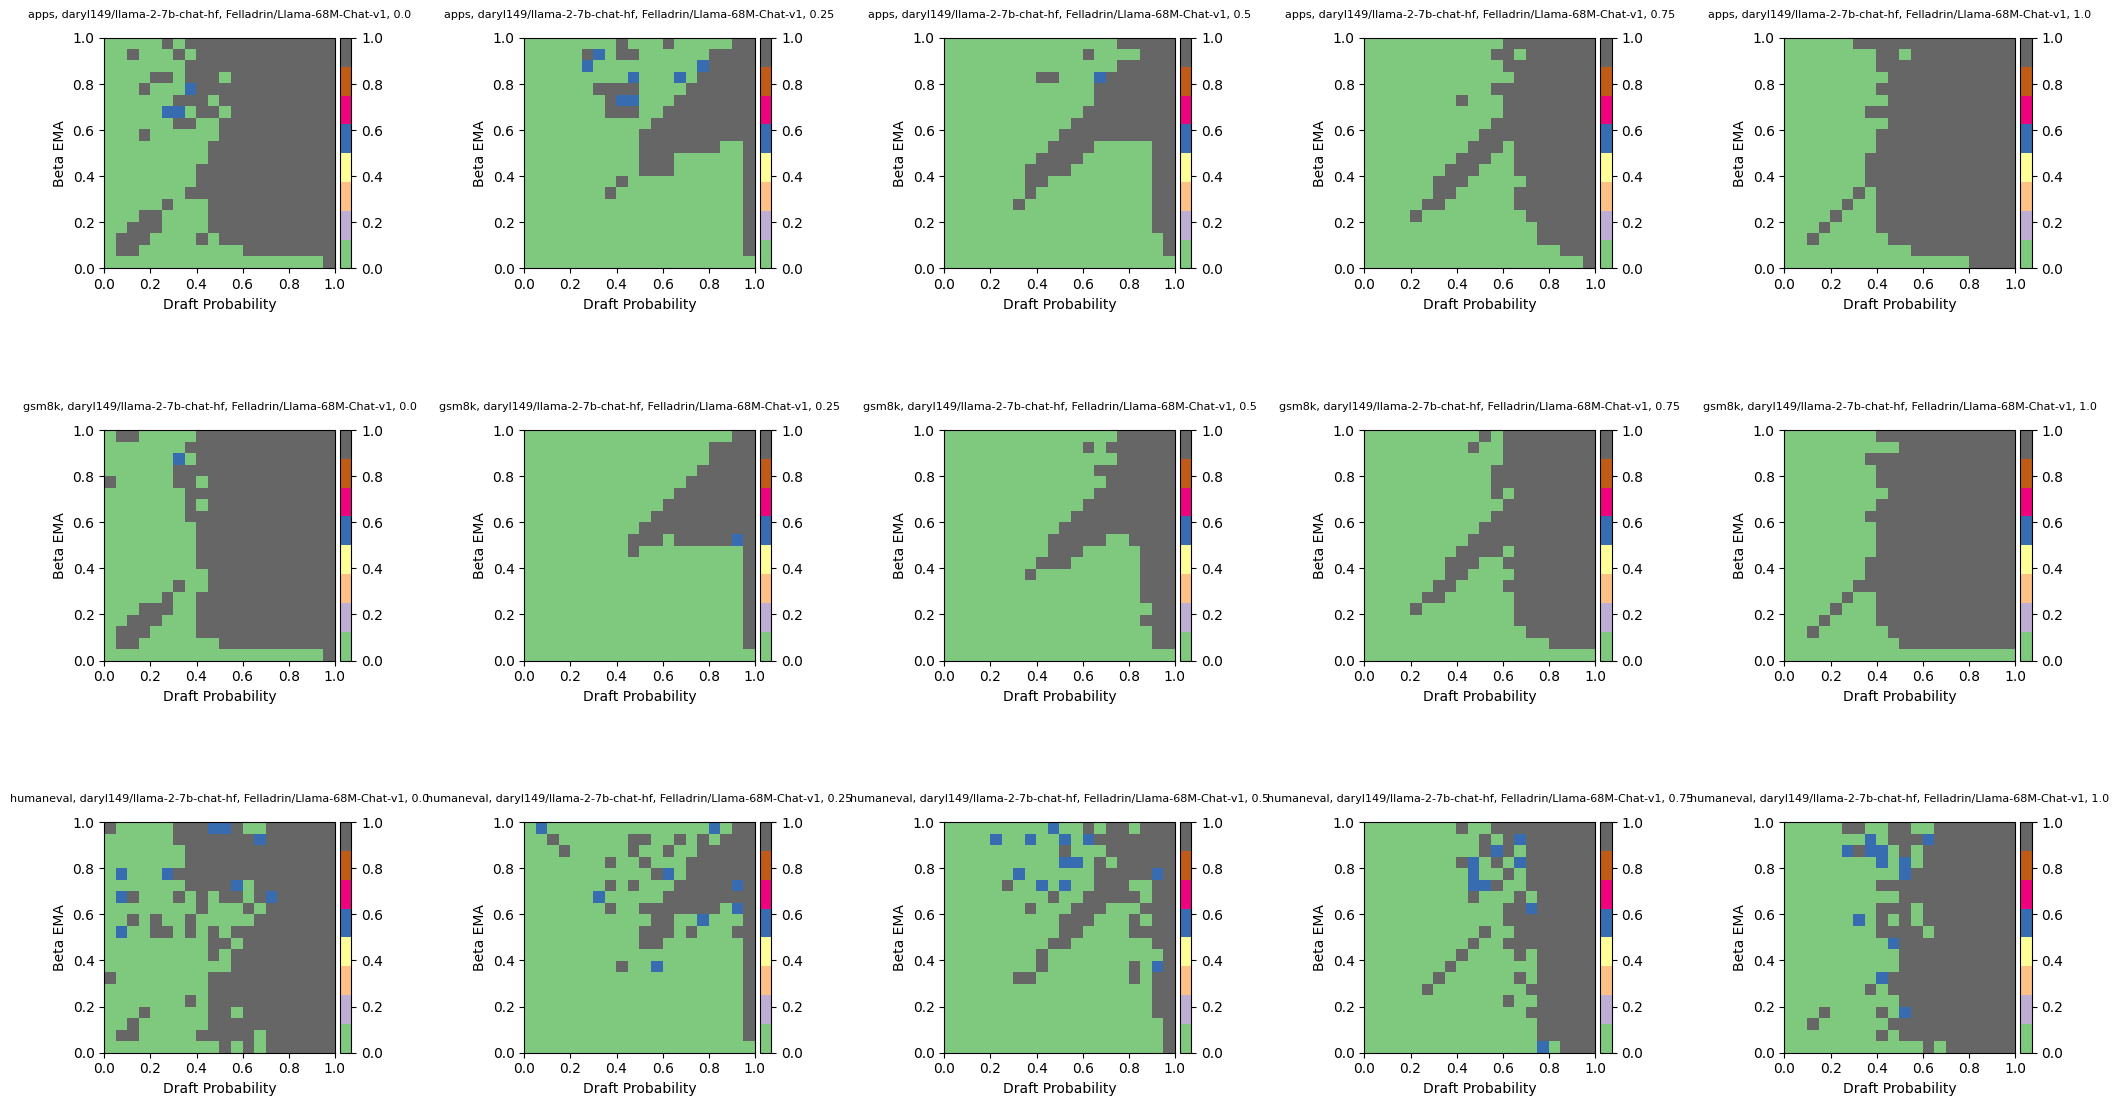

In [3]:
num_results = len(RESULT_FILES)
ncols = min(num_results, MAX_COLS)
nrows = int(np.ceil(num_results / MAX_COLS))
plotter = GridPlotter(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
for result_file, ax in tqdm(zip(RESULT_FILES, plotter.iteraxs()), total=num_results):
    try:
        config, binned_df = load_config_binned_df(result_file, "median")
    except:
        continue
    plot_accept_prob_heatmap(binned_df, ax=ax)
    ax.set_title(config, fontsize=8)
plt.subplots_adjust(wspace=0.7, hspace=0.1)